# 2D toy model

This jupyter notebook is the one that I used to developed the ratchet-and-pawl algorithm. It contains many useless things, like many benchmarks for the code. I keep everything here in case I need something that I have already written. If you are interested in the final plots, just look at the notebook called "2D_ToyModel_2".

## Libraries

In [1]:
# Library for linear algebra
import numpy as np
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit

Run the following line without "#" in order to get the plots as windows in the browser (useful to zoom some parts).

In [2]:
## Line to make plot in other windows of browser
#%matplotlib

## Toy model potential

In this jupyter notebook I work with two potentials. The first one is the one that can be found in the article "Transition path theory from biased simulations" (or IrMD in the dropbox).
\begin{equation}
U(x, y)=u_{0}\left\{e^{-\left(x^{2}+y^{2}\right)}-\frac{3}{5} e^{-\left(x^{2}+\left(y-b_{0}\right)^{2}\right)}-e^{-\left(\left(x-x_{0}\right)^{2}+y^{2}\right)}\right.\left.-e^{-\left(\left(x+x_{0}\right)^{2}+y^{2}\right)}\right\}+w_{0}\left[x^{4}+\left(y-a_{0}\right)^{4}\right]
\end{equation}
The potential is a 2D potential that has three minima around $\mathbf{x_R} = (x_R,
yR) = (-1, 0)$, $\mathbf{x_I} = (x_I , y_I ) = (0, 1.5)$, and $\mathbf{x_P} = (x_P, y_P) = (1,
0)$, respectively.

The second potential is a potential also symmetric with respect to the x-axis.
\begin{equation}
U(x, y)=u_{0}\left\{e^{-\left(x^{2}+y^{2}\right)}-\frac{4}{3} e^{-\left(x^{2}+\left(y-b_{0}\right)^{2}\right)}-\frac{4}{3} e^{-\left(x^{2}+\left(y+b_{0}\right)^{2}\right)}-e^{-\left(\left(x-x_{0}\right)^{2}+y^{2}\right)}\right.\left.-e^{-\left(\left(x+x_{0}\right)^{2}+y^{2}\right)}\right\}+w_{0}\left[x^{4}+\left(y-a_{0}\right)^{4}+\left(y+a_{0}\right)^{4}\right]
\end{equation}
Both potentials that I use are parametrised with the following parameters:
\begin{align}
    &x_0=1 \\
    &a_0=\frac{1}{3} \\
    &b_0=\frac{5}{3} \\
    &u_0=5 \\
    &w_0=\frac{1}{5} 
\end{align}

In [3]:
# Parameters of the potentials
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

Here I define the functions that evaluate the potentials and the forces. The functions "potential" and "force" correspond to the first potential (in this notebook I do not study the second potential, I do it in the notebook "2D_ToyModel_2").

In [4]:
@njit
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])


@njit
def potential2(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 4.0/3.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - 4.0/3.0*np.exp(-(q[0]**2 + (q[1] + b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4 + (q[1] + a0)**4)
    return U

@njit
def force2(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-(x2+(q[1]+ b0)**2))
    e4 = np.exp(-((q[0] - x0)**2 + y2))
    e5 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -4.0/3.0*q[0]*e2 -4.0/3.0*q[0]*e3 - (q[0]-x0)*e4 - (q[0]+x0)*e5)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -4.0/3.0*(q[1] - b0)*e2 -4.0/3.0*(q[1] + b0)*e3 - q[1]*e4 - q[1]*e5)-4.0*w0*(q[1] - a0)**3-4.0*w0*(q[1] + a0)**3

    return np.array([fx, fy])

With this function I define the reactant state and the product state as function of the coordinate q. The definition is arbitrary. Notice that the minimum of the intermediate state is just a bit more of -2.41.

In [5]:
@njit
def state(q): #State of the point q. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp = q[0]**2 + 1 + q[1]**2 #Precompute this quantity to speed the code
    if tmp - 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Product state
            state = 1
    if tmp + 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Reactant state
            state = -1
    return state

Function to evaluate the euclidean distance from the reactant state. It is used for the the ratchet-and-pawl Molecular Dynamics.

In [6]:
@njit
def z_dist(q):
    return np.sqrt((q[0] - 1)**2 + q[1]**2) # Distance from the center of the product state

Now I plot the first potential and the force that a particle feels in order to understand the problem better.

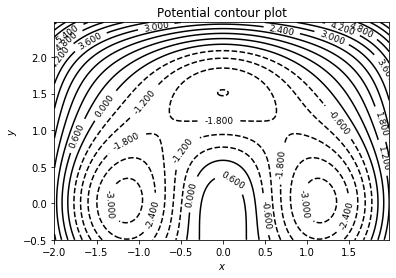

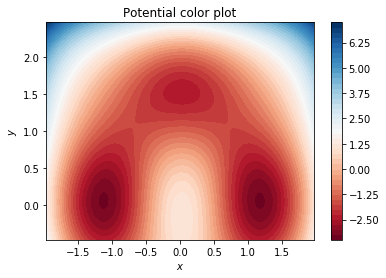

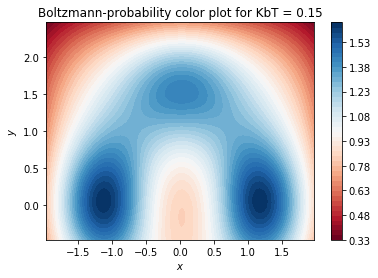

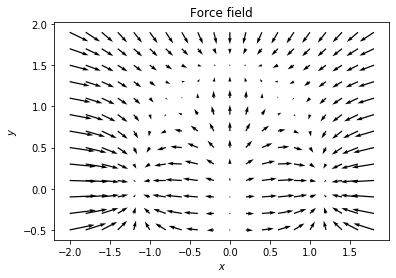

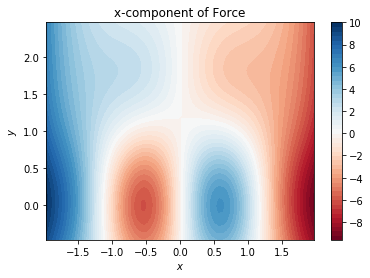

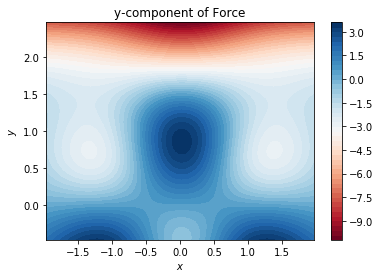

In [7]:
### Contour plot
# Dimension and resolution of the plot
x = np.arange(-2.0, 2.0, 0.025)
y = np.arange(-0.5, 2.5, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix 
I = X*0+1
# Potential to plot
U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4)
U = U1 + U2
# Plot
plt.figure()
CS = plt.contour(X, Y, U, 20, colors='k')
plt.clabel(CS, fontsize=9, inline=1)
# Title and label
plt.title('Potential contour plot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')



### Color plot of the potential
# Grid of the plot
dx, dy = 0.05, 0.05
# Generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Potential to plot
U1 = u0*(np.exp(-(x**2 + y**2)) - 3.0/5.0*np.exp(-(x**2 + (y - b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4)
U = U1+ U2
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., U, levels=levels,cmap=cmap)
plt.colorbar()
# Title and labels
plt.title('Potential color plot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


### Color plot of the Gibbs distribution for KbT = 0.15
# Grid of the plot
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Potential to plot
U1 = u0*(np.exp(-(x**2 + y**2)) - 3.0/5.0*np.exp(-(x**2 + (y - b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4)
U = np.exp(-0.15*(U1+ U2))
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
cf = plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., U, levels=levels, cmap=cmap)
plt.colorbar()
plt.title('Boltzmann-probability color plot for KbT = 0.15')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()



### Vector field of the force field
# Grid of the plot
x,y = np.meshgrid(np.arange(-2.0,2.0,0.2),np.arange(-0.5,2.0,0.2))
# Identity matrix
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
# Force components
fx = 2*u0*(x*e1 -3.0/5.0*x*e2 - (x-x0)*e3 - (x+x0)*e4)-4.0*w0*x**3
fy = 2*u0*(y*e1 -3.0/5.0*(y - b0)*e2 - y*e3 - y*e4)-4.0*w0*(y - a0)**3
# Plot of force field
plt.figure()
plt.quiver(x,y,fx,fy, units='width')
# Title and labels
plt.title("Force field")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()



### Colour plot of the x-component of the force
# Grid of the plot
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
# X-component of the force
Fx = 2*u0*(x*e1 -3.0/5.0*x*e2 - (x-x0*I)*e3 - (x+x0*I)*e4)-4.0*w0*x**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fx = Fx[:-1, :-1]
levelsX = MaxNLocator(nbins=50).tick_values(Fx.min(), Fx.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapX = plt.get_cmap('RdBu')
norm = BoundaryNorm(levelsX, ncolors=cmapX.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., Fx, levels=levelsX,cmap=cmapX)
plt.colorbar()
# Title and labels
plt.title('x-component of Force')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()



### Colour plot of the y-component of the force
# Grid of the plot
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
# Y-component of the force
Fy = 2*u0*(y*e1 -3.0/5.0*(y - b0*I)*e2 - y*e3 - y*e4)-4.0*w0*(y - a0*I)**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fy = Fy[:-1, :-1]
levelsY = MaxNLocator(nbins=50).tick_values(Fy.min(), Fy.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapY = plt.get_cmap('RdBu')
normY = BoundaryNorm(levelsY, ncolors=cmapY.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., Fy, levels=levelsY,cmap=cmapY)
plt.colorbar()
# Title and labels
plt.title('y-component of Force')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Now I do the same with the other potential.

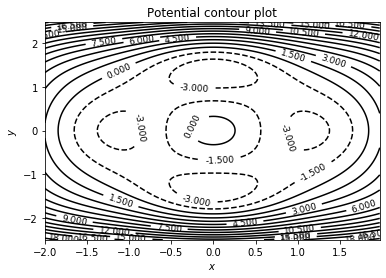

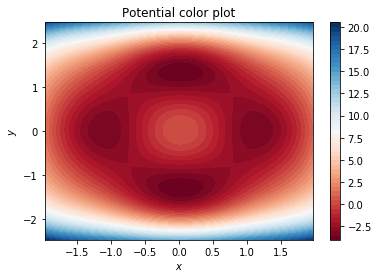

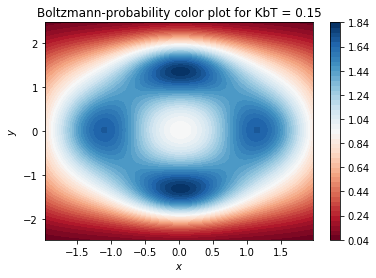

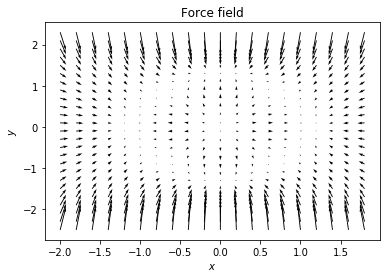

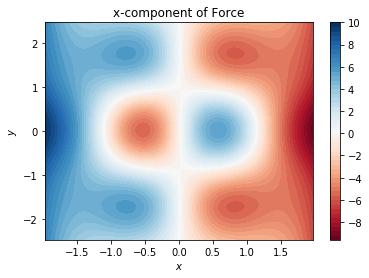

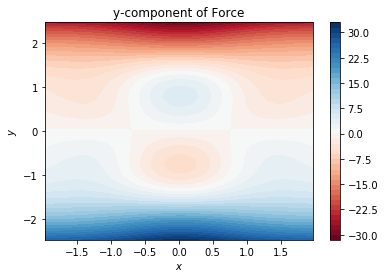

In [8]:
### Contour plot
# Dimension and resolution of the plot
x = np.arange(-2.0, 2.0, 0.025)
y = np.arange(-2.5, 2.5, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix 
I = X*0+1
# Potential to plot
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
U = U1 + U2
# Plot
plt.figure()
CS = plt.contour(X, Y, U, 20, colors='k')
plt.clabel(CS, fontsize=9, inline=1)
# Title and label
plt.title('Potential contour plot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')



### Color plot of the potential
# Grid of the plot
dx, dy = 0.05, 0.05
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-2.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Potential to plot
U1 = u0*(np.exp(-(x**2 + y**2)) - 4.0/3.0*np.exp(-(x**2 + (y - b0*I)**2)) - 4.0/3.0*np.exp(-(x**2 + (y + b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4 + (y + a0*I)**4)
U = U1+ U2
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., U, levels=levels,cmap=cmap)
plt.colorbar()
# Title and labels
plt.title('Potential color plot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()



### Color plot of the Gibbs distribution for KbT = 0.15
# Grid of the plot
y, x = np.mgrid[slice(-2.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Probability distribution to plot
U1 = u0*(np.exp(-(x**2 + y**2)) - 4.0/3.0*np.exp(-(x**2 + (y - b0*I)**2)) - 4.0/3.0*np.exp(-(x**2 + (y + b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4 + (y + a0*I)**4)
U = np.exp(-0.15*(U1+ U2))
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
cf = plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., U, levels=levels, cmap=cmap)
plt.colorbar()
# Title and labels
plt.title('Boltzmann-probability color plot for KbT = 0.15')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


### Vector field of the force field
# Grid of the plot
x,y = np.meshgrid(np.arange(-2.0,2.0,0.2),np.arange(-2.5,2.5,0.2))
# Identity matrix
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-(x**2+(y+ b0*I)**2))
e4 = np.exp(-((x - x0*I)**2 + y**2))
e5 = np.exp(-((x + x0*I)**2 + y**2))
# Force components
fx = 2*u0*(x*e1 -4.0/3.0*x*e2 -4.0/3.0*x*e3 - (x-x0)*e4 - (x+x0)*e5)-4.0*w0*x**3
fy = 2*u0*(y*e1 -4.0/3.0*(y - b0)*e2 -4.0/3.0*(y + b0)*e3 - y*e4 - y*e5)-4.0*w0*(y - a0)**3-4.0*w0*(y + a0)**3
# Plot of force field
plt.figure()
plt.quiver(x,y,fx,fy, units='width')
# Title and labels
plt.title("Force field")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()



### Colour plot of the x-component of the force
# Grid of the plot
y, x = np.mgrid[slice(-2.5, 2.5 + dy, dy), slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-(x**2+(y+ b0*I)**2))
e4 = np.exp(-((x - x0*I)**2 + y**2))
e5 = np.exp(-((x + x0*I)**2 + y**2))
# X-component of the force
Fx = 2*u0*(x*e1 -4.0/3.0*x*e2 -4.0/3.0*x*e3 - (x-x0*I)*e4 - (x+x0*I)*e5)-4.0*w0*x**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fx = Fx[:-1, :-1]
levelsX = MaxNLocator(nbins=50).tick_values(Fx.min(), Fx.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapX = plt.get_cmap('RdBu')
norm = BoundaryNorm(levelsX, ncolors=cmapX.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., Fx, levels=levelsX,cmap=cmapX)
plt.colorbar()
# Title and labels
plt.title('x-component of Force')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

### Colour plot of the y-component of the force
# Grid of the plot
y, x = np.mgrid[slice(-2.5, 2.5 + dy, dy),slice(-2.0, 2.0 + dx, dx)]
# Identity matrix
I = x*0+1
# Exponentials of the force field
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-(x**2+(y+ b0*I)**2))
e4 = np.exp(-((x - x0*I)**2 + y**2))
e5 = np.exp(-((x + x0*I)**2 + y**2))
# Y-component of the force
Fy = 2.0*u0*(y*e1 -4.0/3.0*(y - b0*I)*e2 -4.0/3.0*(y + b0*I)*e3 - y*e4 - y*e5)-4.0*w0*(y - a0*I)**3-4.0*w0*(y + a0*I)**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fy = Fy[:-1, :-1]
levelsY = MaxNLocator(nbins=50).tick_values(Fy.min(), Fy.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapY = plt.get_cmap('RdBu')
normY = BoundaryNorm(levelsY, ncolors=cmapY.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., Fy, levels=levelsY,cmap=cmapY)
plt.colorbar()
# Title and labels
plt.title('y-component of Force')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

# Langevin equation

Now I integrate numerically the Langevin equation. I chose to write my quantities in $\gamma$ units (i.e. $\gamma = 1$) and in units of mass (i.e. $m = 1$). In this units the diffusion coefficient is equal to $K_b T$.

I integrate the Langevin equation in the following way:
\begin{equation}
    \mathbf{q}(t+\Delta t) = \mathbf{q}(t)+\mathbf{f}(t)*\Delta t + \sqrt{2 K_B T}*\mathbf{R}(0,1)
\end{equation}
where $\mathbf{R}(0,1)$ is a random vector with components that are Gaussian distributed with unitary variance and zero mean.

The following code integrates the Langevin equation of motion.  

In [9]:
@njit
def LI(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
    return q[1:,:]

The following code instead plots the histogram of the trajectories that we plot. The function takes as input all the trajectories together (the variable that is called "trajall" below), the edges of the plot (given as two lists) and the resolution of the histogram.

In [10]:
def plot_prob_distr(trajectories, xedge, yedge, delta):
    ## Density plot of how much time the system passes in a given point
    # Borders of the plot
    xedges = np.arange(xedge[0],xedge[1], delta).tolist()
    yedges = np.arange(yedge[0],yedge[1], delta).tolist()
    # Load the data
    x = trajectories[:,0]
    y = trajectories[:,1]
    # Create the histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
    H = H.T  # Let each row list bins with common y range.
    plt.figure()
    im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax = plt.gca()
    # colormap, colorbar, labels, ect.
    im.set_cmap('RdBu')
    # contour lines
    x = np.arange(xedge[0],xedge[1], 0.025)
    y = np.arange(yedge[0],yedge[1], 0.025)
    X, Y = np.meshgrid(x, y)
    # Identity matrix
    I = X*0+1
    # Probability of the 
    U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
    U2 = w0*(X**4 + (Y - a0*I)**4)
    Z = np.exp(-KBT*(U1 + U2))
    CS = plt.contour(X, Y, Z, 15, colors='k')
    # labels and title
    plt.title("Sampling transition region")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    plt.show()

Now I see what happens when I start in the intermediate state and when I am at the temperature $K_b T = 0.15$.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q0' of function 'LI'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b4fa27aa920c>", line 2:
@njit
def LI(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


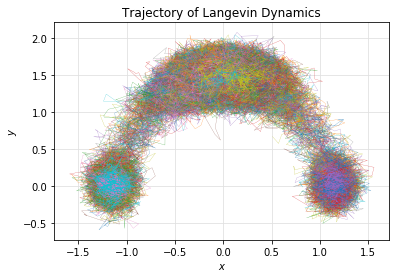

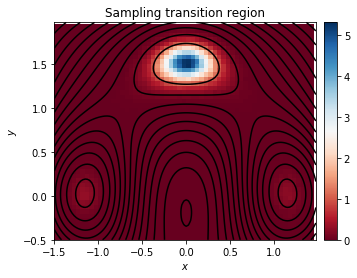

In [11]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [0.0, 1.5]  # Initial conditions
    traj = LI(q0, KbT = KBT, isteps = 500)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-0.5, 2.0], 0.05)

The file with all the trajectories is very big, as we can see.

In [12]:
print(trajall.shape)

(499499, 2)


I cut the part of the trajectories that are in the reactant or product state. I keep only the points with an high energy (bigger than an arbitrary value -2.41) and that are far away the reactant and product state. I do this in order to check later the code with that keeps only the reactive trajectories.

In [ ]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.41:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)

We can see how much information we lose if we do this.

In [ ]:
print(trajall.shape)
print(trajcut.shape)

Let's finally plot the density probability of the cutted trajectory.

In [ ]:
### Probability density plot
plot_prob_distr(tracut, [-1.5, 1.5], [-0.5, 2.0], 0.05)

Now I begin to consider only the reactive trajectories. I start from an algorithm that does not consider the product state: I code a new integrator that stops when a particle reaches the product state.

In [ ]:
@njit
def LI_Cut(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    tmp = 0
    while i < isteps - 1 and tmp == 0:
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        i += 1
        if (q[i,0]-1)**2+q[i,1]**2 < 1.0: # Check if we are in product state
            U = potential(q[i,:])
            if U < -2.4:
                tmp = 1.0    #Exit loop
    return q[1:i-1,:]

I run the new integrator to see if it is implemented correctly.

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [0.0, 1.5]  # Initial conditions
    traj = LI_Cut(q0, KbT = KBT, isteps = 1000)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-0.5, 2.0], 0.05)

# Langevin in a potential well

Now I start from the reactant state and not from the intermediate one. If we put our Brownian particle in the reactant state, we see that it is very unlikely to exit from the potential well if we are at low temperature ($K_b T = 0.15).

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj = LI(q0, KbT = KBT, isteps = 1000)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-0.5, 2.0], 0.05)

Now I consider only the trajectories cutted in the product state.

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj = LI_Cut(q0, KbT = KBT, isteps = 1000)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, -0.8], [-0.5, 2.0], 0.05)

Finally I do something more refined: I consider only the reactive trajectories. I attach a number to each point of the trajectory: if we are in the in the reactant state I attach a -1, if we are in the product state I attach a 1, otherwise I attach a 0 (this is done by the function called "state"). Then I consider only the part of the trajectory that is between two points with a -1 and a 1.

In [ ]:
@njit
def LI_R(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        i += 1
        s = state(q[i,:])

    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

To see the correctness of the code, I run the integrator at a bigger temperature (to have enough reactive trajectories).

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 1.5
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj = LI_R(q0, KbT = KBT)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.05)

## Steered Langevin in a potential wall

As we have seen, the particle spends a lot of time in the reactant state when we are at a low temperature. We can push it towards the product state using an extra force. For the moment I consider a constant force towards the center of the product state:
\begin{equation}
    \mathbf{f}_{bias} = - k_s \left(\mathbf{q} - \mathbf{x}_P \right)
\end{equation}

In [ ]:
@njit
def LI_S(q0, dt = 0.02, KbT = 0.15, ks = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    for i in range(isteps-1):
        # Evaluate evolution of the system
        z = z_dist(q[i,:])
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*(q[i,0] - 1.0)*dt/z
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*q[i,1]*dt/z
    return q[1:,:]

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj = LI_S(q0, KbT = KBT, ks = 5, isteps = 100)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.3, 1.5], [-0.5, 1.2], 0.02)

As I did before, I cut the trajectory and I look at what is left (just to be sure that the code that considers only reactive trajectories is correct)

In [ ]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.4:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)
    
    
### Probability density plot
plot_prob_distr(trajcut, [-1.3, 1.5], [-0.5, 1.2], 0.02)

Now I do as before: I consider only the reactive trajectories (but with the bias force)

In [ ]:
@njit
def LI_RS(q0, dt = 0.02, KbT = 0.15, ks = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])   
        z = z_dist(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*(q[i,0]-1.0)*dt/z
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*q[i,1]*dt/z
        i += 1
        s = state(q[i,:])

    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

Let's see what happens for $K_B T = 0.15$.

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj = LI_RS(q0, KbT = KBT, ks = 5)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()



### Probability density plot
plot_prob_distr(trajall, [-0.9, 0.9], [-0.5, 1.2], 0.02)

Finally I implement the ratchet-and-pawl Molecular Dynamics. The force is defined in the following way
\begin{equation}
    \mathbf{F}_{\mathrm{rMD}}=-\frac{k_{R}}{2} \nabla z(\mathbf{x}) \xi\left(z(\mathbf{x})-z_{\min }(t)\right) \theta\left(z(\mathbf{x})-z_{\min }(t)\right)
\end{equation}
with 
\begin{equation}
    z(\mathbf{x})=\sqrt{\left(x-x_{P}\right)^{2}+\left(y-y_{P}\right)^{2}}
\end{equation}
where $z_{\min }(t)$ denotes the smallest value assumed by $z$ up to time $t$ and $k_R$ is an elastic constant, and $\xi(x)$ is a function which is positive definite for $x > 0$ (in the present work, we used $\xi(x) = x$).

In [ ]:
@njit
def LI_RMD(q0, dt = 0.02, KbT = 0.15, kr = 50, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    z = np.empty(isteps, dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    tmp = 0
    zmin = z_dist(q[0,:])
    for i in range(isteps - 1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        z[i] = z_dist(q[i,:])
        if z[i] < zmin:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmin = z[i]
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*(q[i,0]-1.0)*dt/z[i]
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*q[i,1]*dt/z[i]
    z[-1] = z_dist(q[-1,:])
    return q[1:,:], z

Let's see what we get

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj, z = LI_RMD(q0, KbT = KBT, kr = 50, isteps = 500)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    #plt.plot(z) # This line can be uncommented to see how the z coordinate evolves during the runs
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()



### Probability density plot
plot_prob_distr(trajall, [-1.2, 1.5], [-0.4, 1.5], 0.02)

In [ ]:
As always I cut the trajectories.

In [ ]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.4:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)

            
### Probability density plot
plot_prob_distr(trajcut, [-1.2, 1.5], [-0.4, 1.5], 0.02)

Now it is time to consider only reactive trajectories. This corresponds to the final algorithm (the one we want).

In [ ]:
@njit
def LI_RRMD(q0, dt = 0.02, KbT = 0.15, kr = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    z = np.empty(isteps, dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmin = z_dist(q[0,:])
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        z[i] = z_dist(q[i,:])
        if z[i] < zmin:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmin = z[i]
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*(q[i,0]-1.0)*dt/z[i]
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*q[i,1]*dt/z[i]
        i += 1
        s = state(q[i,:])
        
    z[i] = z_dist(q[i,:])
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outz = np.empty(1, dtype=np.float64)
        outz[0] = 0.0
        return out, z
        
    return q[j+1:i-1,:], z[j+1:i-1]

Let's see what we get!

In [ ]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [-1.0, 0.0]  # Initial conditions
    traj, z = LI_RRMD(q0, KbT = KBT, kr = 50)  # I run the integrator
    # Way to put all the trajectories together
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    # Plot of the single trajectory
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    #plt.plot(z) # This line can be uncommented to see how the z coordinate evolves during the runs
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()



### Probability density plot
plot_prob_distr(trajall, [-0.9, 1.2], [-0.4, 1.4], 0.02)

So we got the code that we wanted. Moreover we can check that the plot shown in "IrMD" are the same, so the code seems correct.